# Comparing Bandit Agents

The notebook (`compare.ipynb`) compares the performance of different bandit agents. The `compare.py` script is for command-line execution. They are automatically paired using `jupytext -s`. 

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, sys
from typing import List
import multiprocessing

cores =  multiprocessing.cpu_count() - 1

from bart_playground.bandit.sim_util import *
from compare_agents import (
    AgentSpec, compare_agents_across_scenarios, print_summary_results, plot_comparison_results,
    _ca_logger
)
# from bart_playground.bandit.rome.rome_scenarios import HomogeneousScenario, NonlinearScenario
from drinkless import DrinkLessScenario

In [2]:
from bart_playground.bandit.bcf_agent import BCFAgent, BCFAgentPSOff
from bart_playground.bandit.basic_agents import SillyAgent, LinearTSAgent
from bart_playground.bandit.ensemble_agent import EnsembleAgent
from bart_playground.bandit.me_agents import HierTSAgent, LinearTSAgent2, LinearUCBAgent, METSAgent
from bart_playground.bandit.bart_agent import BARTAgent, LogisticBARTAgent, DefaultBARTAgent, MultiChainBARTAgent
from bart_playground.bart import DefaultBART, LogisticBART

from bart_playground.bandit.TEagents import TEAgent

### Initialization

In [3]:
# Initialize Numba

bart_ini = DefaultBART(ndpost=1, nskip=1, n_trees=25)
logistic_bart_ini = LogisticBART(ndpost=1, nskip=1, n_trees=25)

# Simple dataset
X_ini = np.random.uniform(-1, 1, size=(100, 1))
y_ini = np.sin(2 * np.pi * X_ini) + np.random.normal(0, 0.1, size=X_ini.shape)

bart_ini.fit(X_ini, y_ini)

Iterations: 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


### Simulation Parameters

In [ ]:
# default scenario
default_arg = ['Wine', 'Heart', 'Iris', 'DrinkLess']
# include more agent variations
extensive = True

n_simulations = 8  # Number of simulations per scenario
sim_indices = list(range(n_simulations))  # Indices for simulations
max_draws = 2000      # Number of draws per simulation

profile = False # Profile the simulation (if True, will use a profiler)

### Scenarios and Agents

In [5]:
has_gpu = True
try:
    import torch
    from bart_playground.bandit.neural_paper_agents import NeuralTSDiagAgent, LinearTSDiagAgent, KernelTSDiagAgent, NeuralTSAgent, NLinearTSAgent, NKernelTSAgent
except:
    has_gpu = False
    _ca_logger.warning("Neural agents not available. Skipping GPU-based agents.")

WARNING bandit_simulator — Neural agents not available. Skipping GPU-based agents.


#### Scenarios

In [6]:
# Create test scenarios
scenario_factories = {
    "Linear": lambda: LinearScenario(P=10, K=5, d=2, sigma2=1.0),
    "GLM": lambda: GLMScenario(P=5, K=5, sigma2=1.0),
    "Friedman": lambda: FriedmanScenario(P=10, K=2, sigma2=1.0),
    "Friedman2": lambda: FriedmanScenario(P=4, K=2, sigma2=1.0, f_type='friedman2'),
    "Friedman3": lambda: FriedmanScenario(P=4, K=2, sigma2=1.0, f_type='friedman3'),
    "LinFriedman": lambda: LinearFriedmanScenario(P=10, K=2, sigma2=1.0),
    "Sparse": lambda: FriedmanScenario(P=20, K=5, sigma2=1.0),
    ## "Isolet": lambda: OpenMLScenario('isolet', version=1),
    "Magic": lambda: OpenMLScenario('MagicTelescope', version=1),
    "Adult": lambda: OpenMLScenario('adult', version=2),
    "Shuttle": lambda: OpenMLScenario('shuttle', version=1),
    ## "Letter": lambda: OpenMLScenario('letter', version=1),
    "Mushroom": lambda: OpenMLScenario('mushroom', version=1),
    "Covertype": lambda: OpenMLScenario('covertype', version=3),
    "MNIST": lambda: OpenMLScenario('mnist_784', version=1),
    "Iris": lambda: OpenMLScenario('iris', version=1),
    "Wine": lambda: OpenMLScenario('wine-quality-red', version=1),
    "Heart": lambda: OpenMLScenario('heart-disease', version=1,
                                    target_column='target'), # Cleveland Heart Disease dataset
    "DrinkLess": lambda: DrinkLessScenario(),
    
}

# Parse command-line arguments
args = sys.argv[1:]
cli = True

# Determine which scenarios to run; default if none or invalid
if len(args) == 0 or not any(arg in scenario_factories for arg in args):
    print(f"No valid scenarios specified, using {default_arg}.")
    args = default_arg
    cli = False

selected_keys = [k for k in scenario_factories if k in args]
scenarios = {key: scenario_factories[key]() for key in selected_keys}

rep_dataset = selected_keys[0]
# log_encoding = 'native' if rep_dataset in ['Adult', 'Magic', 'Mushroom'] else 'multi' 

if has_gpu:
    torch.manual_seed(0)
    torch.cuda.manual_seed_all(0)

No valid scenarios specified, using ['DrinkLess'].
No mismatches in Dataset A or C.
Dataset A and C align.


#### Agents

In [7]:
all_agent_specs: List[AgentSpec] = []
more_agent_specs = []

if has_gpu:
    print("Has GPU, test NeuralTS agents") 
    all_agent_specs = [
        ("NeuralTSDiag", NeuralTSDiagAgent, {}),
        # ("NeuralTS", NeuralTSAgent, {}),
        ("NLinearTS", NLinearTSAgent, {}),
        ("NKernelTS", NKernelTSAgent, {}),
    ]
else:
    print("No GPU, test BART agents") 
    all_agent_specs = [
        ("Random",      SillyAgent,      {'random_state':0}),
        ("XGBoostTS", TEAgent, {'agent_type': 'xgboost'}),
        ("RFTS", TEAgent, {'agent_type': 'random_forest'}),
        # ("BARTs",       DefaultBARTAgent,       {}),
        ("BARTm",       DefaultBARTAgent,       {}),
        ("BARTo",       DefaultBARTAgent,       {}),
        ("LogisticBARTm", LogisticBARTAgent, {}),
        ("LogisticBARTo", LogisticBARTAgent, {}),
        # ("MCBARTs",     MultiChainBARTAgent, { 'bart_class': DefaultBART }),
        # ("MCBARTm",     MultiChainBARTAgent, { 'bart_class': DefaultBART }),
        # ("LogisticMCBARTm", MultiChainBARTAgent, { 'bart_class': LogisticBART }),
        ("LinearTS",   LinearTSAgent,   {'v':1}),
        # ("LinearTSme",  LinearTSAgent2,  {}),
        # ("RoME",             RoMEAgent,              {'featurize':_featurize, 't_max':n_draws, 'pool_users':False}),
        # ("StandardTS",       StandardTSAgent,        {'featurize':_featurize}),
        # ("ActionCenteredTS", ActionCenteredTSAgent,  {'featurize':_featurize}),
        # ("IntelligentPooling", IntelligentPoolingAgent, {'featurize':_featurize, 't_max':n_draws}),
        # ("BCF",        BCFAgent,        {'nskip':100, 'ndpost':100, 'nadd':3, 'nbatch':1, 'random_state':0}),
        # ("Ensemble",   EnsembleAgent,   {
        #     'bcf_kwargs':       dict(nskip=100, ndpost=10, nadd=2, random_state=0),
        #     'linear_ts_kwargs': dict(v=1)
        # }),
        # ("BCF_PSOff",  BCFAgentPSOff,   {'nskip':100, 'ndpost':10, 'nadd':2, 'nbatch':1, 'random_state':0}),
    ]

    # generate more agent specifications for parameter variations
    for agent_name, agent_class, agent_kwargs in all_agent_specs:
        agent_kwargs['random_state'] = 0
        if 'BART' in agent_name:
            agent_kwargs['nskip'] = 30
            agent_kwargs['ndpost'] = 30
            agent_kwargs['n_trees'] = 50 # default number of trees
            agent_kwargs['nadd'] = 2 # default number of additional iterations

            if 'BARTm' in agent_name:
                agent_kwargs['encoding'] = 'multi'
            elif 'BARTo' in agent_name:
                agent_kwargs['encoding'] = 'one-hot'
            elif 'BARTs' in agent_name:
                agent_kwargs['encoding'] = 'separate'

            if not 'MCBART' in agent_name:
                agent_kwargs_new = agent_kwargs.copy()
                agent_kwargs_new['n_trees'] = 25
                more_agent_specs.append((f"{agent_name}_tree0.5x", agent_class, agent_kwargs_new.copy()))
                agent_kwargs_new['n_trees'] = 100
                more_agent_specs.append((f"{agent_name}_tree2x", agent_class, agent_kwargs_new.copy()))
                agent_kwargs_new = agent_kwargs.copy()
                agent_kwargs_new['nadd'] = 1
                more_agent_specs.append((f"{agent_name}_iter0.5x", agent_class, agent_kwargs_new.copy()))
                agent_kwargs_new['nadd'] = 4
                more_agent_specs.append((f"{agent_name}_iter2x", agent_class, agent_kwargs_new.copy()))
            else:
                agent_kwargs['nadd'] = 1 # MultiChainBART only needs to use one additional iteration
                agent_kwargs['n_ensembles'] = 4 # default number of ensembles          

No GPU, test BART agents


In [8]:
if extensive:
    all_agent_specs.extend(more_agent_specs)
    agent_specs = sorted(all_agent_specs, key=lambda x: x[0])
else:
    # If not extensive, we only keep some of the agents (do not include MCBART)
    agent_specs = [
        agent for agent in all_agent_specs if "MCBART" not in agent[0]
    ]

### Initialization

In [9]:
if not has_gpu:
    # Initialize numba
    bart_ini = DefaultBART(ndpost=1, nskip=1, n_trees=25)
    logistic_bart_ini = LogisticBART(ndpost=1, nskip=1, n_trees=25)

    # Simple dataset
    X_ini = np.random.uniform(-1, 1, size=(100, 1))
    y_ini = np.sin(2 * np.pi * X_ini) + np.random.normal(0, 0.1, size=X_ini.shape)

    bart_ini.fit(X_ini, y_ini)

Iterations: 100%|██████████| 2/2 [00:00<00:00, 995.56it/s]


### Simulation

In [10]:
if cli:
    results_dir = "./results/compare_cli" # call from CLI
else:
    results_dir = "./results/compare_test_nb" # call from notebook
os.makedirs(results_dir, exist_ok=True)

def call_func():
    return compare_agents_across_scenarios(
        scenarios=scenarios,
        agent_specs=agent_specs,
        sim_indices=sim_indices,
        max_draws=max_draws,
        parallel=False,
        save_dir=results_dir,
        log_to_file=True
    )

In [11]:
if profile and not cli:
    %prun -s cumtime -D profile_clog.prof -q call_func()
    !gprof2dot -f pstats profile_clog.prof -o profile_clog.dot
    !dot -Tpng profile_clog.dot -o profile_clog.png
    pass  # For notebook, we run the function and generate a profile
else:
    results = call_func()

INFO bandit_simulator — Logging detailed information to ./results/compare_test_nb/logs.
INFO bandit_simulator — Evaluating DrinkLess scenario...
INFO bandit_simulator — Sequentially running simulation.
INFO bandit_simulator — Progress: 0/6. Current sim index: 0. 


Random Forest parameters - exploration_variance: 1.0 n_estimators: 100


Simulating:   0%|          | 0/120 [00:00<?, ?it/s]INFO:root:t = 10 - re-trained model
INFO:root:t = 10 - re-trained model
Simulating:   8%|▊         | 9/120 [00:00<00:06, 17.95it/s]INFO:root:t = 11 - re-trained model
INFO:root:t = 11 - re-trained model
Simulating:   8%|▊         | 10/120 [00:01<00:13,  8.24it/s]

Fitting initial BART model with first 11 observation(s)... Done.
Fitting initial BART model with first 11 observation(s)... Done.
Fitting initial BART model with first 11 observation(s)... Done.
Fitting initial BART model with first 11 observation(s)... Done.
Fitting initial BART model with first 11 observation(s)... Done.
Fitting initial BART model with first 11 observation(s)... Done.
Fitting initial BART model with first 11 observation(s)... Done.
Fitting initial BART model with first 11 observation(s)... Done.
Fitting initial BART model with first 11 observation(s)... Done.
Fitting initial BART model with first 11 observation(s)...

Simulating:   9%|▉         | 11/120 [00:03<00:49,  2.18it/s]

 Done.


INFO:root:t = 13 - re-trained model
INFO:root:t = 13 - re-trained model
Simulating:  10%|█         | 12/120 [00:04<01:01,  1.76it/s]INFO:root:t = 14 - re-trained model
INFO:root:t = 14 - re-trained model
Simulating:  12%|█▏        | 14/120 [00:04<00:49,  2.12it/s]INFO:root:t = 16 - re-trained model
INFO:root:t = 16 - re-trained model
Simulating:  13%|█▎        | 16/120 [00:05<00:42,  2.45it/s]INFO:root:t = 18 - re-trained model
INFO:root:t = 18 - re-trained model
Simulating:  16%|█▌        | 19/120 [00:06<00:33,  3.04it/s]INFO:root:t = 21 - re-trained model
INFO:root:t = 21 - re-trained model
Simulating:  18%|█▊        | 21/120 [00:07<00:35,  2.82it/s]INFO:root:t = 23 - re-trained model
INFO:root:t = 23 - re-trained model
Simulating:  20%|██        | 24/120 [00:08<00:27,  3.50it/s]INFO:root:t = 26 - re-trained model
INFO:root:t = 26 - re-trained model
Simulating:  23%|██▎       | 28/120 [00:09<00:21,  4.30it/s]INFO:root:t = 30 - re-trained model
INFO:root:t = 30 - re-trained model
Simu

Random Forest parameters - exploration_variance: 1.0 n_estimators: 100


Simulating:   0%|          | 0/120 [00:00<?, ?it/s]

Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)...

Simulating:   4%|▍         | 5/120 [00:06<02:22,  1.24s/it]

 Done.


Simulating:   7%|▋         | 8/120 [00:07<01:00,  1.85it/s]INFO:root:t = 10 - re-trained model
INFO:root:t = 10 - re-trained model
Simulating:   8%|▊         | 9/120 [00:07<01:01,  1.82it/s]INFO:root:t = 11 - re-trained model
INFO:root:t = 11 - re-trained model
Simulating:   9%|▉         | 11/120 [00:08<00:46,  2.33it/s]INFO:root:t = 13 - re-trained model
INFO:root:t = 13 - re-trained model
Simulating:  10%|█         | 12/120 [00:08<00:54,  1.99it/s]INFO:root:t = 14 - re-trained model
INFO:root:t = 14 - re-trained model
Simulating:  12%|█▏        | 14/120 [00:09<00:45,  2.35it/s]INFO:root:t = 16 - re-trained model
INFO:root:t = 16 - re-trained model
Simulating:  13%|█▎        | 16/120 [00:10<00:40,  2.56it/s]INFO:root:t = 18 - re-trained model
INFO:root:t = 18 - re-trained model
Simulating:  16%|█▌        | 19/120 [00:11<00:29,  3.42it/s]INFO:root:t = 21 - re-trained model
INFO:root:t = 21 - re-trained model
Simulating:  18%|█▊        | 21/120 [00:12<00:32,  3.02it/s]INFO:root:t = 23 -

Random Forest parameters - exploration_variance: 1.0 n_estimators: 100


Simulating:   0%|          | 0/120 [00:00<?, ?it/s]INFO:root:t = 10 - re-trained model
INFO:root:t = 10 - re-trained model
Simulating:   8%|▊         | 9/120 [00:00<00:06, 16.63it/s]INFO:root:t = 11 - re-trained model
INFO:root:t = 11 - re-trained model
Simulating:   8%|▊         | 10/120 [00:01<00:14,  7.84it/s]INFO:root:t = 13 - re-trained model
INFO:root:t = 13 - re-trained model
Simulating:  10%|█         | 12/120 [00:01<00:19,  5.65it/s]INFO:root:t = 14 - re-trained model
INFO:root:t = 14 - re-trained model
Simulating:  11%|█         | 13/120 [00:02<00:26,  4.00it/s]INFO:root:t = 16 - re-trained model
INFO:root:t = 16 - re-trained model
Simulating:  12%|█▎        | 15/120 [00:02<00:29,  3.61it/s]INFO:root:t = 18 - re-trained model
INFO:root:t = 18 - re-trained model
Simulating:  14%|█▍        | 17/120 [00:03<00:30,  3.34it/s]INFO:root:t = 21 - re-trained model
INFO:root:t = 21 - re-trained model
Simulating:  17%|█▋        | 20/120 [00:04<00:28,  3.53it/s]INFO:root:t = 23 - re-trai

Fitting initial BART model with first 24 observation(s)... Done.
Fitting initial BART model with first 24 observation(s)... Done.
Fitting initial BART model with first 24 observation(s)... Done.
Fitting initial BART model with first 24 observation(s)... Done.
Fitting initial BART model with first 24 observation(s)... Done.
Fitting initial BART model with first 24 observation(s)... Done.
Fitting initial BART model with first 24 observation(s)... Done.
Fitting initial BART model with first 24 observation(s)... Done.
Fitting initial BART model with first 24 observation(s)... Done.
Fitting initial BART model with first 24 observation(s)...

Simulating:  20%|██        | 24/120 [00:07<00:50,  1.88it/s]INFO:root:t = 26 - re-trained model


 Done.


INFO:root:t = 26 - re-trained model
Simulating:  23%|██▎       | 28/120 [00:08<00:31,  2.94it/s]INFO:root:t = 30 - re-trained model
INFO:root:t = 30 - re-trained model
Simulating:  27%|██▋       | 32/120 [00:09<00:22,  3.96it/s]INFO:root:t = 34 - re-trained model
INFO:root:t = 34 - re-trained model
Simulating:  30%|███       | 36/120 [00:11<00:19,  4.24it/s]INFO:root:t = 38 - re-trained model
INFO:root:t = 38 - re-trained model
Simulating:  34%|███▍      | 41/120 [00:12<00:16,  4.77it/s]INFO:root:t = 43 - re-trained model
INFO:root:t = 43 - re-trained model
Simulating:  39%|███▉      | 47/120 [00:14<00:13,  5.38it/s]INFO:root:t = 49 - re-trained model
INFO:root:t = 49 - re-trained model
Simulating:  44%|████▍     | 53/120 [00:16<00:12,  5.38it/s]INFO:root:t = 55 - re-trained model
INFO:root:t = 55 - re-trained model
Simulating:  50%|█████     | 60/120 [00:18<00:09,  6.15it/s]WARNING bandit_simulator — No data for context [1. 1. 1.] and treatment arm 1. Ensure the context matches the da

Random Forest parameters - exploration_variance: 1.0 n_estimators: 100


Simulating:   0%|          | 0/120 [00:00<?, ?it/s]INFO:root:t = 10 - re-trained model
INFO:root:t = 10 - re-trained model
Simulating:   8%|▊         | 9/120 [00:00<00:05, 19.91it/s]

Fitting initial BART model with first 10 observation(s)... Done.
Fitting initial BART model with first 10 observation(s)... Done.
Fitting initial BART model with first 10 observation(s)... Done.
Fitting initial BART model with first 10 observation(s)... Done.
Fitting initial BART model with first 10 observation(s)... Done.
Fitting initial BART model with first 10 observation(s)... Done.
Fitting initial BART model with first 10 observation(s)... Done.
Fitting initial BART model with first 10 observation(s)... Done.
Fitting initial BART model with first 10 observation(s)... Done.
Fitting initial BART model with first 10 observation(s)...

INFO:root:t = 11 - re-trained model


 Done.


INFO:root:t = 11 - re-trained model
Simulating:   9%|▉         | 11/120 [00:03<00:40,  2.70it/s]INFO:root:t = 13 - re-trained model
INFO:root:t = 13 - re-trained model
Simulating:  10%|█         | 12/120 [00:03<00:46,  2.35it/s]INFO:root:t = 14 - re-trained model
INFO:root:t = 14 - re-trained model
Simulating:  12%|█▏        | 14/120 [00:04<00:41,  2.54it/s]INFO:root:t = 16 - re-trained model
INFO:root:t = 16 - re-trained model
Simulating:  13%|█▎        | 16/120 [00:05<00:40,  2.60it/s]INFO:root:t = 18 - re-trained model
INFO:root:t = 18 - re-trained model
Simulating:  16%|█▌        | 19/120 [00:06<00:32,  3.13it/s]INFO:root:t = 21 - re-trained model
INFO:root:t = 21 - re-trained model
Simulating:  18%|█▊        | 21/120 [00:07<00:36,  2.71it/s]INFO:root:t = 23 - re-trained model
INFO:root:t = 23 - re-trained model
Simulating:  20%|██        | 24/120 [00:08<00:28,  3.37it/s]INFO:root:t = 26 - re-trained model
INFO:root:t = 26 - re-trained model
Simulating:  23%|██▎       | 28/120 [00:

Random Forest parameters - exploration_variance: 1.0 n_estimators: 100


Simulating:   0%|          | 0/120 [00:00<?, ?it/s]

Fitting initial BART model with first 5 observation(s)... Done.
Fitting initial BART model with first 5 observation(s)... Done.
Fitting initial BART model with first 5 observation(s)... Done.
Fitting initial BART model with first 5 observation(s)... Done.
Fitting initial BART model with first 5 observation(s)... Done.
Fitting initial BART model with first 5 observation(s)... Done.
Fitting initial BART model with first 5 observation(s)... Done.
Fitting initial BART model with first 5 observation(s)... Done.
Fitting initial BART model with first 5 observation(s)... Done.
Fitting initial BART model with first 5 observation(s)...

Simulating:   5%|▌         | 6/120 [00:03<01:04,  1.77it/s]

 Done.


Simulating:   7%|▋         | 8/120 [00:03<00:40,  2.74it/s]INFO:root:t = 10 - re-trained model
INFO:root:t = 10 - re-trained model
Simulating:   8%|▊         | 9/120 [00:04<00:48,  2.30it/s]INFO:root:t = 11 - re-trained model
INFO:root:t = 11 - re-trained model
Simulating:   9%|▉         | 11/120 [00:05<00:42,  2.59it/s]INFO:root:t = 13 - re-trained model
INFO:root:t = 13 - re-trained model
Simulating:  10%|█         | 12/120 [00:05<00:47,  2.30it/s]INFO:root:t = 14 - re-trained model
INFO:root:t = 14 - re-trained model
Simulating:  12%|█▏        | 14/120 [00:06<00:39,  2.66it/s]INFO:root:t = 16 - re-trained model
INFO:root:t = 16 - re-trained model
Simulating:  13%|█▎        | 16/120 [00:07<00:37,  2.76it/s]INFO:root:t = 18 - re-trained model
INFO:root:t = 18 - re-trained model
Simulating:  16%|█▌        | 19/120 [00:08<00:31,  3.18it/s]INFO:root:t = 21 - re-trained model
INFO:root:t = 21 - re-trained model
Simulating:  18%|█▊        | 21/120 [00:09<00:35,  2.76it/s]INFO:root:t = 23 -

Random Forest parameters - exploration_variance: 1.0 n_estimators: 100


Simulating:   0%|          | 0/120 [00:00<?, ?it/s]

Fitting initial BART model with first 6 observation(s)... Done.
Fitting initial BART model with first 6 observation(s)... Done.
Fitting initial BART model with first 6 observation(s)... Done.
Fitting initial BART model with first 6 observation(s)... Done.
Fitting initial BART model with first 6 observation(s)... Done.
Fitting initial BART model with first 6 observation(s)... Done.
Fitting initial BART model with first 6 observation(s)... Done.
Fitting initial BART model with first 6 observation(s)... Done.
Fitting initial BART model with first 6 observation(s)... Done.
Fitting initial BART model with first 6 observation(s)...

Simulating:   6%|▌         | 7/120 [00:02<00:39,  2.83it/s]

 Done.


INFO:root:t = 10 - re-trained model
INFO:root:t = 10 - re-trained model
Simulating:   8%|▊         | 9/120 [00:03<00:39,  2.78it/s]INFO:root:t = 11 - re-trained model
INFO:root:t = 11 - re-trained model
Simulating:   9%|▉         | 11/120 [00:04<00:37,  2.91it/s]INFO:root:t = 13 - re-trained model
INFO:root:t = 13 - re-trained model
Simulating:  10%|█         | 12/120 [00:04<00:46,  2.31it/s]INFO:root:t = 14 - re-trained model
INFO:root:t = 14 - re-trained model
Simulating:  12%|█▏        | 14/120 [00:05<00:42,  2.51it/s]INFO:root:t = 16 - re-trained model
INFO:root:t = 16 - re-trained model
Simulating:  13%|█▎        | 16/120 [00:06<00:40,  2.55it/s]INFO:root:t = 18 - re-trained model
INFO:root:t = 18 - re-trained model
Simulating:  16%|█▌        | 19/120 [00:07<00:33,  3.05it/s]INFO:root:t = 21 - re-trained model
INFO:root:t = 21 - re-trained model
Simulating:  18%|█▊        | 21/120 [00:08<00:36,  2.68it/s]INFO:root:t = 23 - re-trained model
INFO:root:t = 23 - re-trained model
Simul

### Summary Results

In [12]:
print_summary_results(results)


=== DrinkLess Scenario ===

Final cumulative regrets (mean ± std):
         Agent  Mean Regret  Std Regret
         BARTm         6.61        1.54
BARTm_iter0.5x         6.06        2.27
  BARTm_iter2x         6.63        0.93
BARTm_tree0.5x         6.81        1.84
  BARTm_tree2x         6.13        1.58
         BARTo         5.30        0.95
BARTo_iter0.5x         6.11        0.79
  BARTo_iter2x         6.46        1.62
BARTo_tree0.5x         5.31        0.67
  BARTo_tree2x         6.40        2.38
      LinearTS         7.95        0.85
          RFTS         4.81        1.21
        Random         9.79        0.79
     XGBoostTS         8.85        1.29

Average computation times (seconds):
         Agent  Mean Time (s)  Std Time (s)
         BARTm         1.2433        0.2357
BARTm_iter0.5x         0.7415        0.1879
  BARTm_iter2x         1.8179        0.2508
BARTm_tree0.5x         0.5713        0.0970
  BARTm_tree2x         2.0978        0.3285
         BARTo         1.0358 

### Visualize Results

Visualize the cumulative regret for each agent across scenarios.

In [13]:
import pickle
appendix_name = list(scenarios.keys())[0]  # Use the first scenario name as appendix
result_filename = os.path.join(results_dir, f"result_{appendix_name}.pkl")
pickle.dump(results, open(result_filename, "wb"))
_ca_logger.info(f"Results saved to {result_filename}")

INFO bandit_simulator — Results saved to ./results/compare_test_nb/result_DrinkLess.pkl


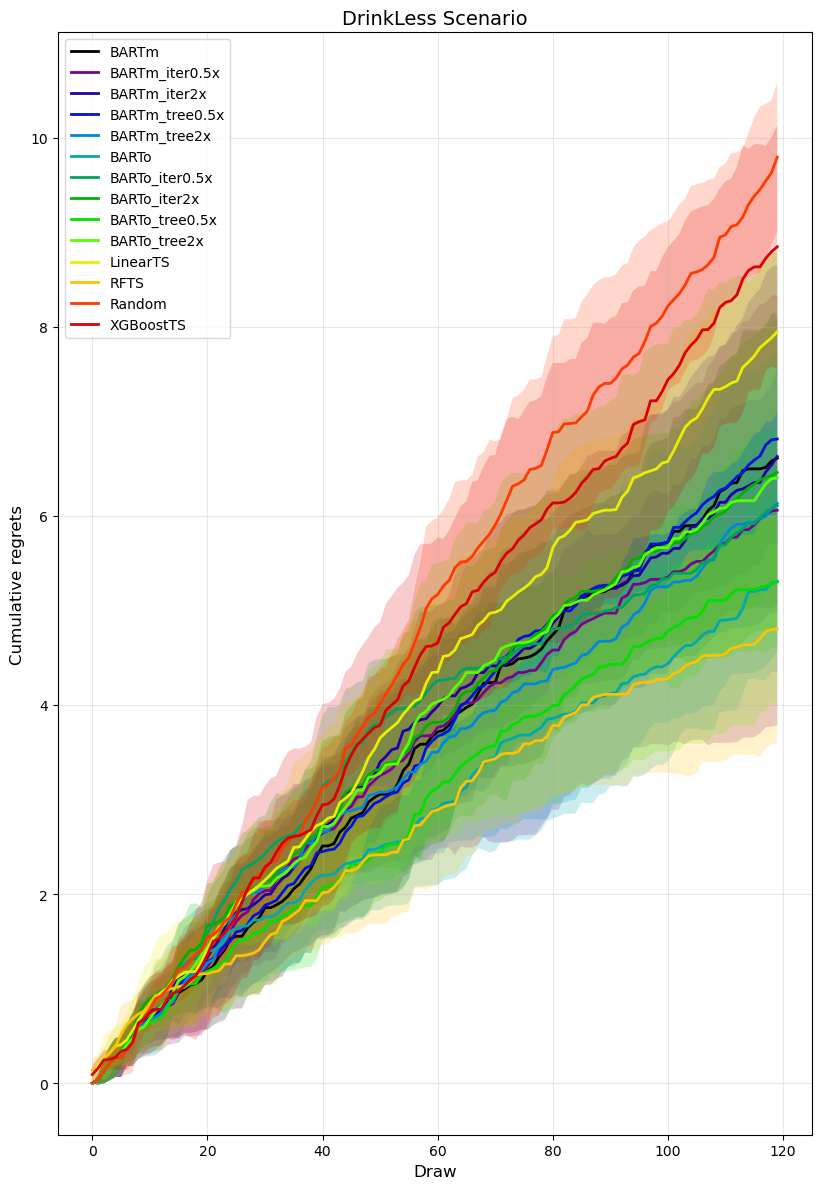

INFO bandit_simulator — Plot saved to ./results/compare_test_nb/agent_comparison_results_DrinkLess.png


In [14]:
results = pickle.load(file=open(result_filename, "rb"))

# Plot results and save to file
plot_comparison_results(
    results=results,
    save_loc=f"{results_dir}/agent_comparison_results_{appendix_name}.png"
)
_ca_logger.info(f"Plot saved to {results_dir}/agent_comparison_results_{appendix_name}.png")